# Исследование надежности заемщиков.


Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.


Описание данных

children — количество детей в семье\
days_employed — общий трудовой стаж в днях\
dob_years — возраст клиента в годах\
education — уровень образования клиента\
education_id — идентификатор уровня образования\
family_status — семейное положение\
family_status_id — идентификатор семейного положения\
gender — пол клиента\
income_type — тип занятости\
debt — имел ли задолженность по возврату кредитов\
total_income — ежемесячный доход\
purpose — цель получения кредита

In [1]:
import pandas as pd

try:
    data = pd.read_csv('/datasets/data.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

In [2]:
data.head(5)

children  days_employed  dob_years education  education_id  \
0         1   -8437.673028         42    высшее             0   
1         1   -4024.803754         36   среднее             1   
2         0   -5623.422610         33   Среднее             1   
3         3   -4124.747207         32   среднее             1   
4         0  340266.072047         53   среднее             1   

      family_status  family_status_id gender income_type  debt   total_income  \
0   женат / замужем                 0      F   сотрудник     0  253875.639453   
1   женат / замужем                 0      F   сотрудник     0  112080.014102   
2   женат / замужем                 0      M   сотрудник     0  145885.952297   
3   женат / замужем                 0      M   сотрудник     0  267628.550329   
4  гражданский брак                 1      F   пенсионер     0  158616.077870   

                      purpose  
0               покупка жилья  
1     приобретение автомобиля  
2               покупка жилья  
3  дополнительное образование  
4             сыграть свадьбу

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


## Предобработка данных

### Удаление пропусков

In [4]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Столбец с пропущенными значениями — `total_income` — хранит данные о доходах. На сумму дохода сильнее всего влияет тип занятости, поэтому заполним пропуски в этом столбце медианным значением по каждому типу из столбца `income_type`.

In [5]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

### Обработка аномальных значений

Отрицательное количество дней трудового стажа в столбце `days_employed` заменим положительными с помощью метода `abs()`.

In [6]:
data['days_employed'] = data['days_employed'].abs()

Выведем медианное значение трудового стажа `days_employed` в днях.

In [7]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У двух типов (безработные и пенсионеры) аномально большие значения. Исправить такие значения сложно, поэтому оставим их как есть. Этот столбец не понадобится нам для исследования.

Выведем перечень уникальных значений столбца `children`.

In [8]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

В столбце `children` есть два аномальных значения. Удалим строки, в которых встречаются такие аномальные значения из датафрейма `data`.

In [9]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

In [10]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

Заполним пропуски в столбце `days_employed` медианными значениями по каждого типа занятости `income_type`.

In [11]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

Убедимся, что все пропуски заполнены.

In [12]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Изменение типов данных

Заменим вещественный тип данных в столбце `total_income` на целочисленный с помощью метода `astype()`.

In [13]:
data['total_income'] = data['total_income'].astype(int)

### Обработка дубликатов

Обработаем неявные дубликаты в столбце `education`. В этом столбце есть одни и те же значения, но записанные по-разному: с использованием заглавных и строчных букв. Приведем их к нижнему регистру.

In [14]:
data['education'] = data['education'].str.lower()

Выведем на экран количество строк-дубликатов в данных, удалим их.

In [15]:
data.duplicated().sum()

71

In [16]:
data = data.drop_duplicates()

### Категоризация данных

На основании диапазонов, указанных ниже, создадим в датафрейме `data` столбец `total_income_category` с категориями:

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

In [17]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [18]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

In [19]:
data.head()

children  days_employed  dob_years education  education_id  \
0         1    8437.673028         42    высшее             0   
1         1    4024.803754         36   среднее             1   
2         0    5623.422610         33   среднее             1   
3         3    4124.747207         32   среднее             1   
4         0  340266.072047         53   среднее             1   

      family_status  family_status_id gender income_type  debt  total_income  \
0   женат / замужем                 0      F   сотрудник     0        253875   
1   женат / замужем                 0      F   сотрудник     0        112080   
2   женат / замужем                 0      M   сотрудник     0        145885   
3   женат / замужем                 0      M   сотрудник     0        267628   
4  гражданский брак                 1      F   пенсионер     0        158616   

                      purpose total_income_category  
0               покупка жилья                     B  
1     приобретение автомобиля                     C  
2               покупка жилья                     C  
3  дополнительное образование                     B  
4             сыграть свадьбу                     C

Выведем на экран перечень уникальных целей взятия кредита из столбца `purpose`.

In [20]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Создадим функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.


In [21]:
def categorize_purpose(row):
    try:
        if 'авто' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [22]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

### Исследуем данные.

#### Исследуем зависимость между количеством детей и возвратом кредита в срок

*Построим сводную таблицу зависимости должников от количества детей, представив в отдельных столбцах количество взятых кредитов, количество и долю должников.*  

In [23]:
data.pivot_table(index='children', values='debt', aggfunc=['count','sum','mean'])

count   sum      mean
           debt  debt      debt
children                       
0         14091  1063  0.075438
1          4808   444  0.092346
2          2052   194  0.094542
3           330    27  0.081818
4            41     4  0.097561
5             9     0  0.000000

Из таблицы видим повшение доли должников у семей с двумя детьми (0.094542) в сравнении с одним ребенком (0.092346), у семей с тремя (0.081818) доля невозврата ниже чем с одним, самый высокий невозврат у семей с четырьмя детьми (0.097561), но мало данныых (41) как и у семей с пятью детьми (9) и (0.00000)

<AxesSubplot:xlabel='children'>

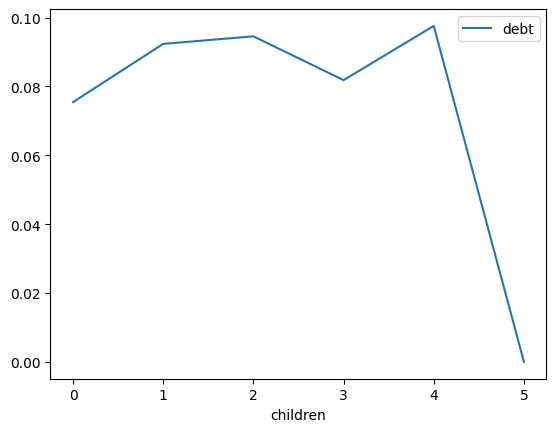

In [24]:
data.pivot_table(index='children', values='debt', aggfunc='mean').plot()

Вывод: у клиентов без детей доля возврата кредита выше чем у семей с детьми. Зависимости возврата кредита в срок от количества детей нет (ввиду недостаточного количества, данные клиентов с пятью, четырьмя и тремя детьми не стоит учитывать). 

#### Зависимость между семейным положением и возвратом кредита в срок

*Построим сводную таблицу зависимости возврата кредита от семейного положения*

In [25]:
data.pivot_table(index='family_status_id', values='debt', aggfunc=['count','sum','mean'])

count  sum      mean
                   debt debt      debt
family_status_id                      
0                 12261  927  0.075606
1                  4134  385  0.093130
2                   951   63  0.066246
3                  1189   84  0.070648
4                  2796  273  0.097639

*0 - женат / замужем,
1 - гражданский брак,
2 - вдовец / вдова,
3 - в разводе,
4 - не женат / не замужем*

*Построим график зависимости возврата кредита от семейного положения*

<AxesSubplot:xlabel='family_status_id'>

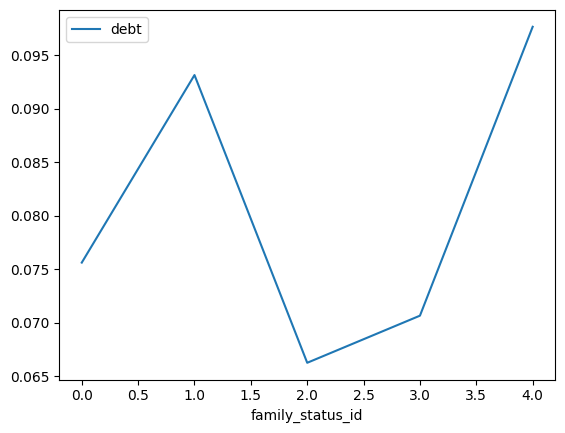

In [26]:
data.pivot_table(index='family_status_id', values='debt', aggfunc='mean').plot()

**Вывод: "вдовец / вдова" и "в разводе"самые надежные клиенты, с небольшим отрывом следуют "женат/замужем", учтем и  преобладающую численность этой категории. Далее в порядке убывания следуют "гражданский брак" и "не женат / не замужем"** 

#### Зависимость между уровнем дохода и возвратом кредита в срок.

*Построим сводную таблицу зависимости возврата кредита от уровня дохода кредитополучателя*

In [27]:
data.pivot_table(index='total_income_category', values='debt', aggfunc=['count','sum','mean'])      

count   sum      mean
                        debt  debt      debt
total_income_category                       
A                         25     2  0.080000
B                       5014   354  0.070602
C                      15921  1353  0.084982
D                        349    21  0.060172
E                         22     2  0.090909

Уровень дохода:\
*0–30000 — 'E';\
30001–50000 — 'D';\
50001–200000 — 'C';\
200001–1000000 — 'B';\
1000001 и выше — 'A'.*

*Видим явное преобладание данных по количеству  заемщиков в категориях 'C' и 'B' (15921 и 5014 соответственно), в сумме три оставшихся категории 'A'+'D'+'E' составляют 1,89% от всех. Данных мало и учитывать их не будем.* 

**Вывод: выше всех доля возврата кредита в срок у кредитополучателей с доходом категории 'B', следом идет категория 'C' с меньшим доходом но с преобладающей численностью. Видим прямую зависимость надежности заемщика от уровня дохода и возвратом кредита в срок, но категории 'A','D' и 'E' малочисленны и не позволяют сделать окончателные выводы.** 

#### Как разные цели кредита влияют на его возврат в срок.

In [28]:
data.pivot_table(index='purpose_category', values='debt', aggfunc=['count','sum','mean'])

count  sum      mean
                           debt debt      debt
purpose_category                              
операции с автомобилем     4279  400  0.093480
операции с недвижимостью  10751  780  0.072551
получение образования      3988  369  0.092528
проведение свадьбы         2313  183  0.079118

<AxesSubplot:xlabel='purpose_category'>

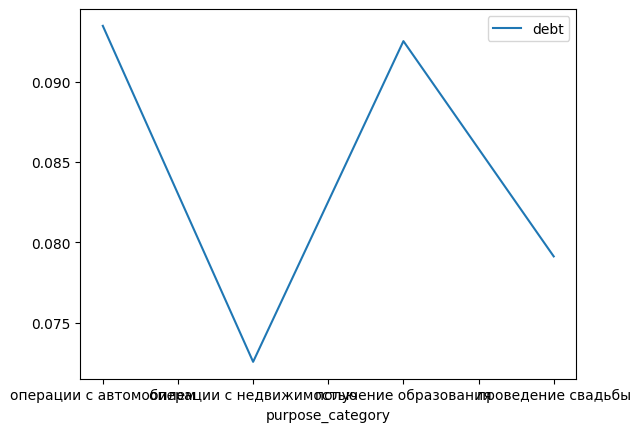

In [29]:
data.pivot_table(index='purpose_category', values='debt', aggfunc='mean').plot()

**Вывод: самые надежные клиенты берут кредит для операций с недвижимостью и проведение свадьбы, далее в порядке убывания следуют цели: получение образования и операции с автомобилем.** 

### Общий вывод.

*В процессе работы исходные данные обработаны, удалены аномалии и дубликаты, пропущенные значения заполнены медианными, а вещественные значения заменены целочисленными. Созданы новае датафреймы и столбцы с категориями, сводные таблицы по зависимостям возврата кредита в срок от количества детей, семейного положения, уровня дохода и цели взятия кредита.*

**У клиентов без детей доля возврата кредита выше чем у семей с детьми. Зависимость возврата кредита в срок от количества детей не обнаружена."Вдовец / вдова" и "в разводе"самые надежные клиенты, с небольшим отрывом следуют "женат/замужем", но учтем преобладающую численность этой категории.
 Способность заемщика оплачивать кредит в срок повышается вместе с доходом, но категории 'A','D' и 'E' малочисленны и не позволяют сделать более точные выводы.**